In [1]:
pip install "jcopdl<2.0"

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.5 MB/s eta 0:00:00
  Created wheel for jcopdl: filename=jcopdl-1.1.10-py2.py3-none-any.whl size=17915 sha256=c10f009569d25dff25215758835dca35ebc7ca67cd7acaee6988c7b355be0ad4
  Store

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
!unzip -q data.zip -d /content/

# Dataset & Dataloader

In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from jcopdl.utils.dataloader import MultilabelDataset

In [5]:
bs = 64
crop_size = 224

train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(crop_size, scale=(0.7, 1)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_set = MultilabelDataset("data/train_label.csv", "data/train/", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True)

test_set = MultilabelDataset("data/test_label.csv", "data/test/", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [6]:
label2cat = train_set.classes
label2cat

['desert', 'mountains', 'sea', 'sunset', 'trees']

# Arsitektur & Config

In [7]:
from torchvision.models import mobilenet_v2

In [8]:
class CustomMobileNetV2(nn.Module):
    def __init__(self, output_size):
        super().__init__()
        self.mnet = mobilenet_v2(weights=True)
        self.freeze()
        self.mnet.classifier = nn.Sequential(
            nn.Linear(1280, output_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.mnet(x)

    def freeze(self):
        for param in self.mnet.parameters():
            param.requires_grad = False

    def unfreeze(self):
        for param in self.mnet.parameters():
            param.requires_grad = True

In [9]:
config = set_config({
    "batch_size": bs,
    "crop_size": crop_size,
    "output_size": len(train_set.classes)

})

# Phase 1: Adaptation

### MCOC

In [10]:
model = CustomMobileNetV2(config.output_size).to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, early_stop_patience=2, outdir="model")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 130MB/s]


### Training

In [11]:
from tqdm.auto import tqdm

In [12]:
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0

    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)

        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        cost += loss.item() * feature.shape[0]

    cost = cost / len(dataset)
    return cost

Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 0.4916 | Test_cost  = 0.3831 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.3484 | Test_cost  = 0.3142 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.3029 | Test_cost  = 0.2833 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.2717 | Test_cost  = 0.2576 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.2613 | Test_cost  = 0.2486 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.2456 | Test_cost  = 0.2395 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.2362 | Test_cost  = 0.2391 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.2311 | Test_cost  = 0.2253 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.2237 | Test_cost  = 0.2276 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2253


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.2210 | Test_cost  = 0.2204 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.2164 | Test_cost  = 0.2243 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2204


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.2112 | Test_cost  = 0.2150 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.2130 | Test_cost  = 0.2131 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 0.2119 | Test_cost  = 0.2179 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2131


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 0.2045 | Test_cost  = 0.2170 | 
==> EarlyStop patience =  2 | Best test_cost: 0.2131
==> Execute Early Stopping at epoch: 15 | Best test_cost: 0.2131
==> Best model is saved at model


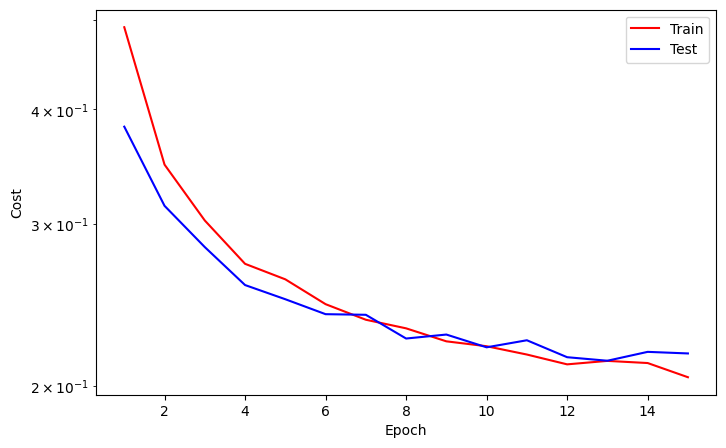

In [13]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)

    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()

    # Runtime Plotting
    callback.cost_runtime_plotting()

    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

# Phase 2: Fine-Tuning

In [14]:
model.unfreeze()
optimizer = optim.AdamW(model.parameters(), lr=0.00001)

callback.reset_early_stop()
callback.early_stop_patience = 5

Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 0.1925 | Test_cost  = 0.2042 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 0.1810 | Test_cost  = 0.1945 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 0.1657 | Test_cost  = 0.1888 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 0.1585 | Test_cost  = 0.1882 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 0.1530 | Test_cost  = 0.1784 | 


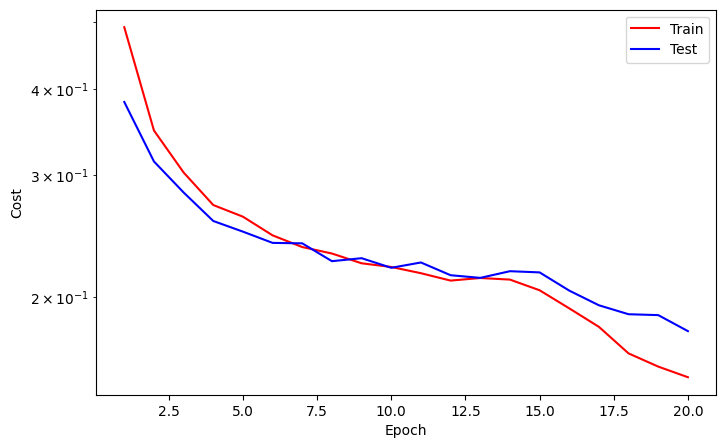

Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 0.1476 | Test_cost  = 0.1805 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1784


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 0.1468 | Test_cost  = 0.1807 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1784


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    23
Train_cost  = 0.1346 | Test_cost  = 0.1722 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    24
Train_cost  = 0.1296 | Test_cost  = 0.1734 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1722


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    25
Train_cost  = 0.1298 | Test_cost  = 0.1690 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    26
Train_cost  = 0.1220 | Test_cost  = 0.1719 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1690


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    27
Train_cost  = 0.1211 | Test_cost  = 0.1689 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    28
Train_cost  = 0.1135 | Test_cost  = 0.1651 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    29
Train_cost  = 0.1119 | Test_cost  = 0.1709 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1651


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    30
Train_cost  = 0.1077 | Test_cost  = 0.1681 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1651


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    31
Train_cost  = 0.1025 | Test_cost  = 0.1629 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    32
Train_cost  = 0.0986 | Test_cost  = 0.1668 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1629


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    33
Train_cost  = 0.1023 | Test_cost  = 0.1642 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1629


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    34
Train_cost  = 0.0967 | Test_cost  = 0.1718 | 
==> EarlyStop patience =  3 | Best test_cost: 0.1629


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    35
Train_cost  = 0.0967 | Test_cost  = 0.1696 | 
==> EarlyStop patience =  4 | Best test_cost: 0.1629


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    36
Train_cost  = 0.0911 | Test_cost  = 0.1586 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    37
Train_cost  = 0.0859 | Test_cost  = 0.1614 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1586


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    38
Train_cost  = 0.0864 | Test_cost  = 0.1579 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    39
Train_cost  = 0.0830 | Test_cost  = 0.1593 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1579


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    40
Train_cost  = 0.0796 | Test_cost  = 0.1579 | 


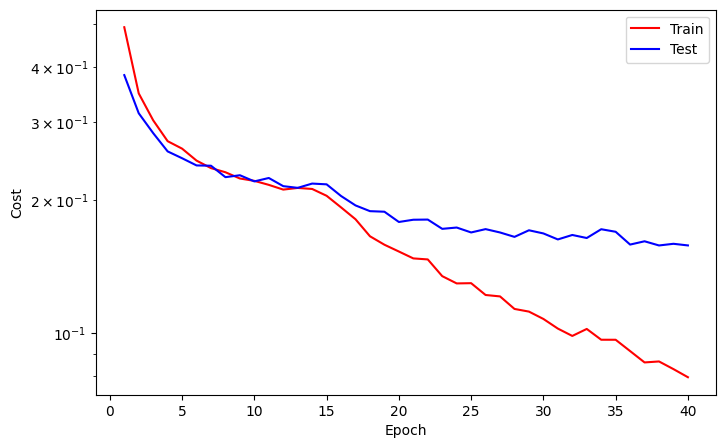

==> EarlyStop patience =  2 | Best test_cost: 0.1579


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    41
Train_cost  = 0.0786 | Test_cost  = 0.1601 | 
==> EarlyStop patience =  3 | Best test_cost: 0.1579


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    42
Train_cost  = 0.0773 | Test_cost  = 0.1580 | 
==> EarlyStop patience =  4 | Best test_cost: 0.1579


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    43
Train_cost  = 0.0747 | Test_cost  = 0.1668 | 
==> EarlyStop patience =  5 | Best test_cost: 0.1579
==> Execute Early Stopping at epoch: 43 | Best test_cost: 0.1579
==> Best model is saved at model


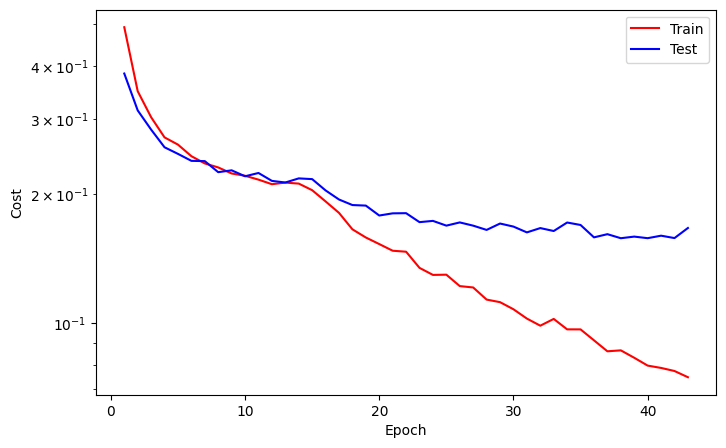

In [15]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)

    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()

    # Runtime Plotting
    callback.cost_runtime_plotting()

    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

# Predict

In [16]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = (output > 0.5).to(torch.float32)

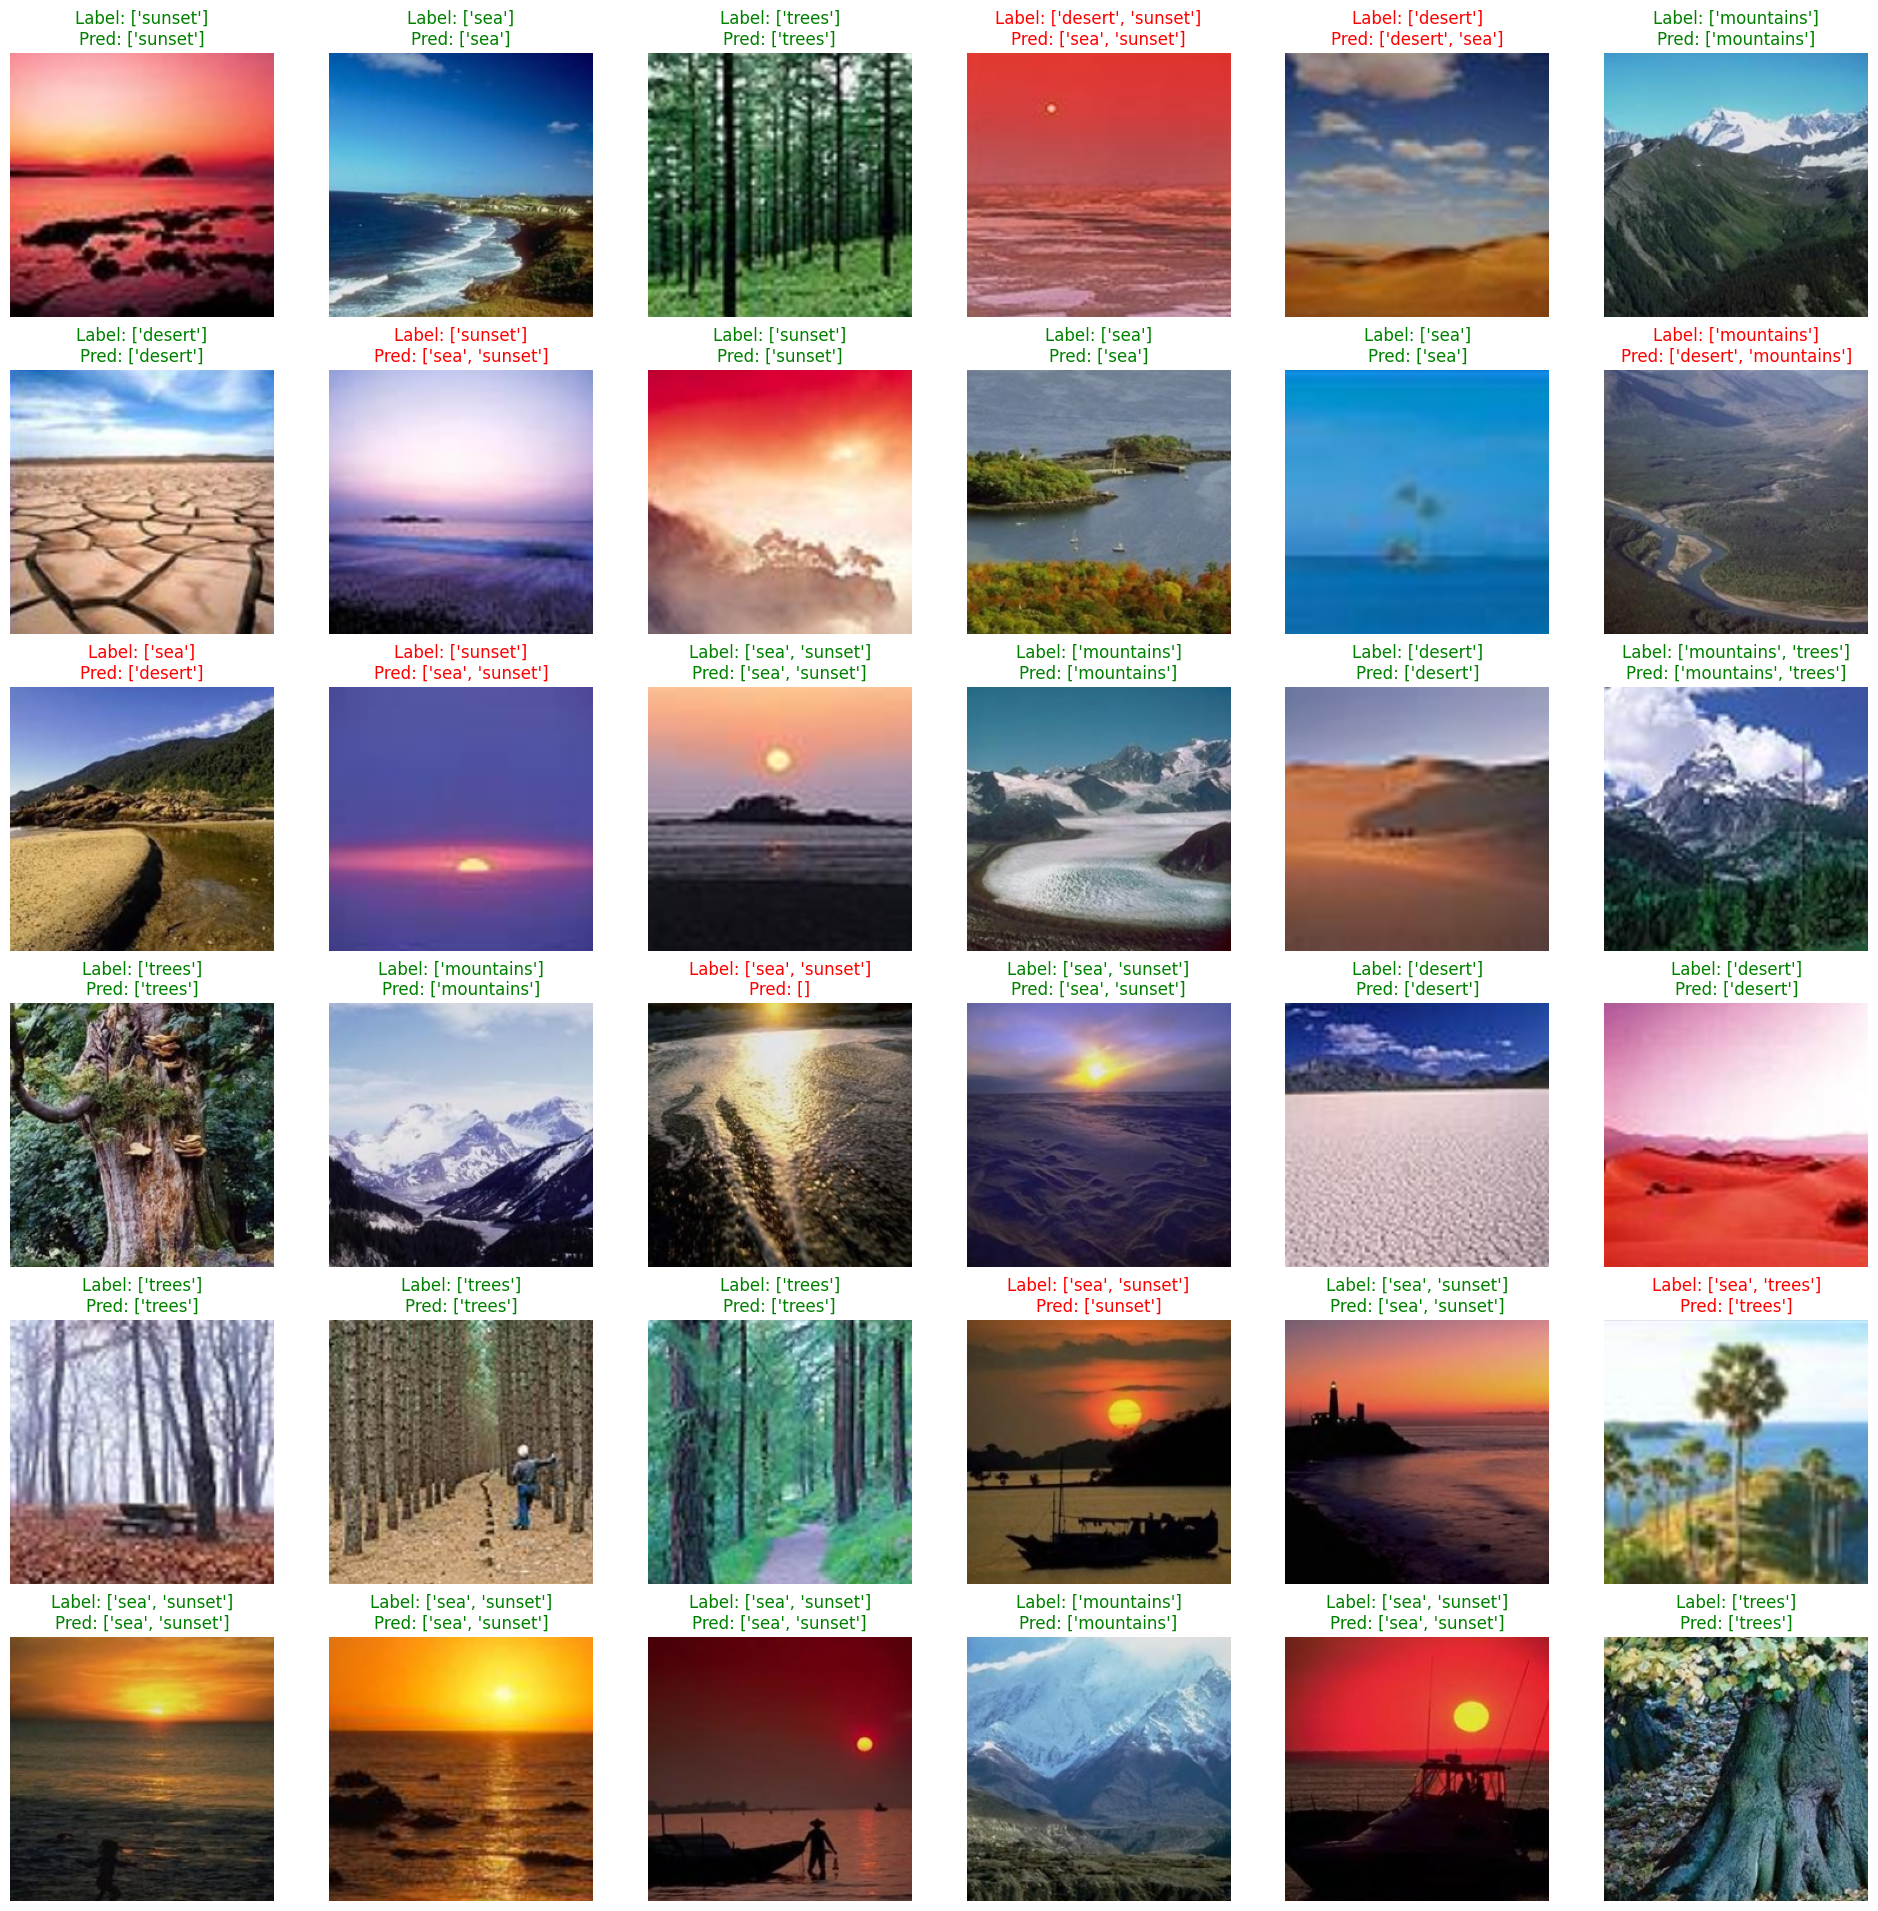

In [17]:
def convert_to_label(x):
    return [label for pred, label in zip(x, label2cat) if pred == 1]

def inverse_norm(img):
    img[0, :, :] = img[0, :, :] * 0.229 + 0.485
    img[1, :, :] = img[1, :, :] * 0.224 + 0.456
    img[2, :, :] = img[2, :, :] * 0.225 + 0.406
    return img

fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(inverse_norm(img).permute(1, 2, 0).cpu())
    font = {"color": 'r'} if (pred != label).any() else {"color": 'g'}
    label = convert_to_label(label)
    pred = convert_to_label(pred)
    ax.set_title(f"Label: {label}\nPred: {pred}", fontdict=font)
    ax.axis('off')

In [18]:
!zip -r model.zip /content/model

  adding: content/model/ (stored 0%)
  adding: content/model/weights_best.pth (deflated 8%)
  adding: content/model/logs.pth (deflated 34%)
